In [1]:
 #accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import *
from MITllc2160Depth import *
sys.path.append("//nobackup/amondal//Python//xmitgcm//xmitgcm")
from xmitgcm.mds_store import open_mdsdataset
import xrft
import xgcm
from spectral_analysis_code import *
from GetNCDataSet import getGEOSNCDataSet

from dask.distributed import Client
client = Client(memory_limit='100GB',n_workers = 40, threads_per_worker=1)

So for calculating Richardson number, you need a few things.
1. Definitely U, V, T, S (U,V for shear, T, S, for density). 
2. Take appropriate derivatives

In [ ]:
import numpy as np
import gsw
import dens # hector can give you this module if you need it
import glob
import scipy.io as io


## load some grid parameters
YC = np.memmap(prnt+'YC_'+str(NX)+'x'+str(NY), dtype = '>f4',shape=(NY,NX), mode='r').astype(float)[1177:-2,1199:2001]
DYF = np.memmap(prnt+'DYF_'+str(NX)+'x'+str(NY), dtype = '>f4',shape=(NY,NX), mode='r').astype(float)[1177:-2,1199:2001]
DXF = np.memmap(prnt+'DXF_'+str(NX)+'x'+str(NY), dtype = '>f4',shape=(NY,NX), mode='r').astype(float)[1177:-2,1199:2001]
RAU = np.memmap(prnt+'RAW_'+str(NX)+'x'+str(NY), dtype = '>f4',shape=(NY,NX), mode='r').astype(float)[1177:-2,1199:2001]
RAV = np.memmap(prnt+'RAS_'+str(NX)+'x'+str(NY), dtype = '>f4',shape=(NY,NX), mode='r').astype(float)[1177:-2,1199:2001]


## get the file list, I am assuming you have already extracted similar files for your study area
Wf = sorted(glob.glob(prnt+'W_'+str(NX)+'x'+str(NY)+'x'+str(NZ)+'.'+suf+'*'))
Tf = sorted(glob.glob(prnt+'Theta_'+str(NX)+'x'+str(NY)+'x'+str(NZ)+'.'+suf+'*'))
Sf = sorted(glob.glob(prnt+'Salt_'+str(NX)+'x'+str(NY)+'x'+str(NZ)+'.'+suf+'*'))
Uf = sorted(glob.glob(prnt+'U_'+str(NX)+'x'+str(NY)+'x'+str(NZ)+'.'+suf+'*'))
Vf = sorted(glob.glob(prnt+'V_'+str(NX)+'x'+str(NY)+'x'+str(NZ)+'.'+suf+'*'))
Ef = sorted(glob.glob(prnt+'Eta_'+str(NX)+'x'+str(NY)+'.'+suf+'*'))

## load the outputs (here the first file in the folder)
layer_max = 50
w_tot = np.memmap(Wf[0], dtype = '>f4',shape=(NZ,NY,NX), mode='r')[:layer_max,1177:-2,1199:2001]
s_tot = np.memmap(Sf[0], dtype = '>f4',shape=(NZ,NY,NX), mode='r')[:layer_max,1177:-2,1199:2001]
t_tot = np.memmap(Tf[0], dtype = '>f4',shape=(NZ,NY,NX), mode='r')[:layer_max,1177:-2,1199:2001]
u_tot = np.memmap(Uf[0], dtype = '>f4',shape=(NZ,NY,NX), mode='r')[:layer_max,1177:-2,1199:2001]
v_tot = np.memmap(Vf[0], dtype = '>f4',shape=(NZ,NY,NX), mode='r')[:layer_max,1177:-2,1199:2001]
eta_tot = np.memmap(Ef[0], dtype = '>f4',shape=(NY,NX), mode='r')[1177:-2,1199:2001]

## select a layer/depth
layer = 14

z = io.loadmat(prnt+'thk90.mat') # I am assuming you already have this file for the depth/level thickness - let me know if not, or ask Hector or Dimitris for where to find it
depth = z['dpt90'][0,:] # level depth (m)

D = depth[2:layer_max]-depth[:layer_max-2]
D = D[:,None,None]
D = np.tile(D,(1,w_tot.shape[1],w_tot.shape[2]))

## compute finite difference, the super basic way
uz = (u_tot[:-2,:,:]-u_tot[2:,:,:])/D #THIS NEEDS TO BE ADJUSTED i think
vz = (v_tot[:-2,:,:]-v_tot[2:,:,:])/D
uz_c = (uz[:,:,:-1]+uz[:,:,1:])/2 # if I remember correctly "_c" means at the center of the cell
vz_c = (vz[:,:-1,:]+vz[:,1:,:])/2
u_z = uz_c[:,1:-1,1:]
v_z = vz_c[:,1:,1:-1]

## load a buoyancy file (I computed it from temperature, salinity, depth and saved it, I think it saved me time instead of recomputing it every time). If you have trouble computing buoyancy, I put a small code that I used below in comments
b = np.load('/Users/siegelma/Documents/Kerguelen_analysis/raw_data/'+suf+'_b.npy')

# ##compute b at a given layer ##
# ref = 1027.5
# rho = dens.densjmd95(s_tot[layer,:,:],t_tot[layer,:,:],depth[layer]) # you can ask Hector the function dens.densjmd95 or use one that you like (e.g., from gsw)
# b[layer,:,:] = 9.81*(1-rho/ref)


b_z = (b[:-2,:,:]-b[2:,:,:])/D
bz = b_z[:,1:-1,1:-1]
b0 = np.zeros((bz.shape[1],bz.shape[2]7))
b0 = b0[None,:]
bz = np.vstack((b0,bz))

# db/dx
b2x = (b[:,:,2:] * DYF[:,2:] - b[:,:,:-2] * DYF[:,:-2])/(RAU[:,1:-1]+RAU[:,:-2])
# db/dx
b2y = (b[:,2:,:] * DXF[2:,:] - b[:,:-2,:] * DXF[:-2,:])/(RAV[1:-1,:]+RAV[:-2,:])
### b_x and b_y are at the cell center ##
b_x = b2x[:,1:-1,:]
b_y = b2y[:,:,1:-1]

Gradb = np.sqrt(b_x**2 + b_y**2)

## Richardson number assuming thermal wind
yc = YC[1:-1,1:-1]
f = gsw.f(yc)
Ri = ((f**2)*bz)/(Gradb[:-1,:,:]**2)

## Richardson number not assuming thermal wind
Ri_real = bz[:-1,:,:]/(u_z**2+v_z**2)


In [3]:
getZlayerThickness(5)

1.93

In [23]:
getZlayerThickness(np.array(range(0,4)))

array([1.  , 1.14, 1.3 , 1.49])

In [2]:
thk = scipy.io.loadmat('../Hector_Python_Scripts/thk90')
thickness = thk['thk90'][0,0:90]
depth = thk['dpt90'][0,0:90]

In [3]:
grid_dir ='/nobackup/amondal/NCData/20220301_grid_vars_for_Ri/'
diag_dir = '/nobackup/amondal/NCData/2020301_diagnostic_vars_for_Ri/'

In [5]:
DXF = getMITNCDataSet(grid_dir, 'dxF', 0,0).compute()
DYF = getMITNCDataSet(grid_dir, 'dyF', 0,0).compute()
RAS = getMITNCDataSet(grid_dir, 'rAs', 0,0).compute()
RAW = getMITNCDataSet(grid_dir, 'rAw', 0,0).compute()
#turns out this is unnecessary for the total Richardson number

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [4]:
diag_dir = '/nobackup/amondal/NCData/20220301_diagnostic_vars_for_Ri_layers0_20/'
SALT = getMITNCDataSet(diag_dir, 'Salt', 0, 6)
THETA = getMITNCDataSet(diag_dir, 'Theta', 0, 6)


Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer


In [5]:
diag_dir = '/nobackup/amondal/NCData/20220301_diagnostic_vars_for_Ri_layers0_20/'
U = getMITNCDataSet(diag_dir, 'U', 0, 6)
V = getMITNCDataSet(diag_dir, 'V', 0, 6)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer


In [3]:
U

<xarray.Dataset>
Dimensions:  (Zlayers: 7, lat: 500, lon: 500, time: 313)
Coordinates:
  * lat      (lat) float64 23.0 23.04 23.08 23.12 ... 42.84 42.88 42.92 42.96
  * lon      (lon) float64 -67.0 -66.96 -66.92 -66.88 ... -47.12 -47.08 -47.04
  * time     (time) datetime64[ns] 2020-03-01 2020-03-01T01:00:00 ... 2020-03-14
Dimensions without coordinates: Zlayers
Data variables:
    U        (Zlayers, time, lat, lon) float64 dask.array<chunksize=(1, 1, 500, 500), meta=np.ndarray>

In [6]:
U = U.U.isel(time=0)
V = V.V.isel(time=0)

In [7]:
S = SALT.Salt.isel(time=0)
T = THETA.Theta.isel(time=0)

In [8]:
U = U.compute()
V = V.compute()

In [11]:
Uv = U.values
Vv = V.values

In [9]:
layer_max = 7
D = depth[2:layer_max]-depth[:layer_max-2]
D = D[:,None,None]
D = np.tile(D,(1,U.shape[1],U.shape[2]))

In [10]:
D.shape

(5, 500, 500)

In [12]:
## compute finite difference, the super basic way
uz = (Uv[:-2,:,:]-Uv[2:,:,:])/D
vz = (Vv[:-2,:,:]-Vv[2:,:,:])/D

#The interpolation is unnecessary for you!

#uz_c = (uz[:,:,:-1]+uz[:,:,1:])/2 # if I remember correctly "_c" means at the center of the cell
#vz_c = (vz[:,:-1,:]+vz[:,1:,:])/2
#u_z = uz_c[:,1:-1,1:]
#v_z = vz_c[:,1:,1:-1]

In [15]:
vz.shape

(5, 500, 500)

In [17]:
Ri_shear = (uz**2 + vz**2)

In [18]:
Ri_shear.shape

(5, 500, 500)

In [20]:
# ##compute b at a given layer ##
import gsw
import dens # hector can give you this module if you need it
layer=1
latitude = 33
b = np.zeros(S.values.shape)
ref = 1027.5
pressure = gsw.p_from_z(-1*depth[0:layer_max],33)
for layers in range(0,layer_max):
    rho = dens.densjmd95(S[layers,:,:], T[layers,:,:], pressure[layers])
# rho = dens.densjmd95(s_tot[layer,:,:],t_tot[layer,:,:],depth[layer]) # you can ask Hector the function dens.densjmd95 or use one that you like (e.g., from gsw)
    b[layers,:,:] = 9.81*(1-rho/ref)

#here, b is not really defined fully yet. We need a few more derivatives

In [23]:
b_z = (b[:-2,:,:]-b[2:,:,:])/D
#bz = b_z[:,1:-1,1:-1] - This is unnecessary because salinity and theta 
b0 = np.zeros((b_z.shape[1],b_z.shape[2]))
b0 = b0[None,:]
bz = np.vstack((b0,b_z)) #THIS SETS THE FIRST LAYER'S BUOYANCY GRADIENT TO BE 0 - WHICH DOES MAKE SENSE

In [24]:
#N2 = xr.DataArray(bz[:-1,:,:], coords = Ri_shear.coords, dims = Ri_shear.dims, name = r'N^2')
bz.shape

(6, 500, 500)

In [25]:
Ri_tot = bz[:-1,:,:] / Ri_shear 

In [26]:
Ri_tot.shape

(5, 500, 500)

In terms of depth coordinates, it's pretty clear that we just drop the surface and bottom coordinate of depth to get
the right coordinates for Ri_tot. However, the lat and lon ones are a bit harder. We may be able to do the same thing.

In [27]:
#THIS NEEDS TO BE DOUBLE CHECKED AND YOU NEED TO MAKE THIS WORK WITH XARRAY AND ALL!
Ri = xr.DataArray(Ri_tot, coords = {"Zlayers": depth[0:layer_max-2], "lat":U.lat, "lon":U.lon}, dims = ['Zlayers', 'lat','lon'], name='Ri')

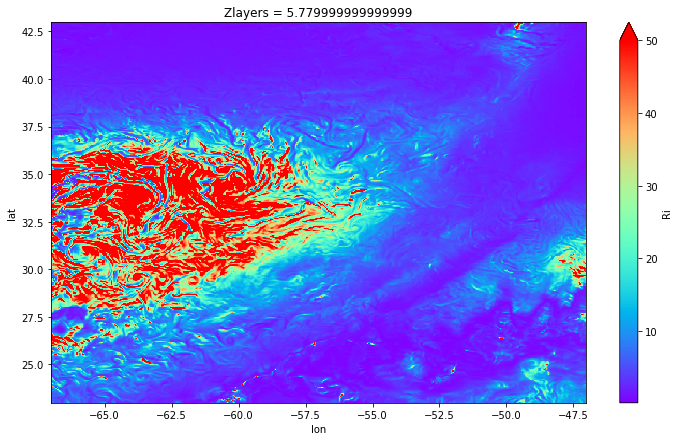

In [63]:
%matplotlib inline
Ri[4].plot(vmin = .1, vmax =50, cmap='rainbow', figsize = (12,7) )

In [60]:
%matplotlib inline
Ri[4].plot(vmin = .1, vmax = 5, cmap='rainbow', figsize= (12,8))

In [69]:
#THIS NEEDS TO BE DOUBLE CHECKED AND YOU NEED TO MAKE THIS WORK WITH XARRAY AND ALL!
InvRi = 1 / Ri
InvRi.name ='Inverse Ri'

In [85]:
%matplotlib inline
InvRi[3].plot(vmin=0.01, vmax=1.5, cmap = 'rainbow', figsize=(12,8))

Double check that you have good colocation of variables. Xarrayify this so that it can handle time coordiantes 

CCS regions - smaller and maybe easier to handle

In [4]:
thk = scipy.io.loadmat('../Hector_Python_Scripts/thk90')
thickness = thk['thk90'][0,0:90]
depth = thk['dpt90'][0,0:90]
layer_min = 12
layer_max = 18

In [5]:
diag_dir = '/nobackup/amondal/NCData/20220301_diagnostic_vars_for_Ri_layers0_40_CCS/'
SALT = getMITNCDataSet(diag_dir, 'Salt', layer_min, layer_max - 1)
THETA = getMITNCDataSet(diag_dir, 'Theta', layer_min, layer_max - 1)
U = getMITNCDataSet(diag_dir, 'U', layer_min, layer_max - 1)
V = getMITNCDataSet(diag_dir, 'V', layer_min, layer_max - 1)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened
I concatenated another Z-layer
Time combined dataset has

In [14]:
Ux = U.U
Vx = V.V


NameError: name 'Zlayers' is not defined

In [10]:

D = depth[layer_min+2:layer_max]-depth[layer_min:layer_max-2]
D = D[:,None, None,None]
D = np.tile(D,(1,Uv.shape[1],Uv.shape[2],Uv.shape[3]))

In [38]:
Dz = xr.DataArray(D, dims=["Zlayers","time","lat","lon"],  coords = {"Zlayers": depth[layer_min+1:layer_max-1], "time":Ux.time, "lat":Ux.lat, "lon":Ux.lon}, name="Depths")
Dz

<xarray.DataArray 'Depths' (Zlayers: 9, time: 313, lat: 75, lon: 75)>
array([[[[ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         ...,
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ]],

        [[ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         ...,
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ]],

        [[ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         [ 8.22 ,  8.22 ,  8.22 , ...,  8.22 ,  8.22 ,  8.22 ],
         ...,
...
         ...,
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ]],

        [[19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         ...,
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ]],

        [[19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         ...,
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ],
         [19.49 , 19.49 , 19.49 , ..., 19.49 , 19.49 , 19.49 ]]]])
Coordinates:
  * Zlayers  (Zlayers) float64 24.99 29.34 34.24 39.72 ... 60.28 68.69 77.97
  * time     (time) datetime64[ns] 2020-03-01 2020-03-01T01:00:00 ... 2020-03-14
  * lat      (lat) float64 35.0 35.04 35.08 35.12 ... 37.84 37.88 37.92 37.96
  * lon      (lon) float64 -126.0 -126.0 -125.9 -125.9 ... -123.1 -123.1 -123.0

In [15]:
Ux = Ux.assign_coords(Zlayers = ("Zlayers", depth[layer_min:layer_max]))
Vx = Vx.assign_coords(Zlayers = ("Zlayers", depth[layer_min:layer_max]))

In [21]:
Uxc = Ux.compute()
Vxc = Vx.compute()

In [20]:
Ux

<xarray.DataArray 'U' (Zlayers: 11, time: 313, lat: 75, lon: 75)>
dask.array<concatenate, shape=(11, 313, 75, 75), dtype=float64, chunksize=(1, 1, 75, 75), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 35.0 35.04 35.08 35.12 ... 37.84 37.88 37.92 37.96
  * lon      (lon) float64 -126.0 -126.0 -125.9 -125.9 ... -123.1 -123.1 -123.0
  * time     (time) datetime64[ns] 2020-03-01 2020-03-01T01:00:00 ... 2020-03-14
  * Zlayers  (Zlayers) float64 21.12 24.99 29.34 34.24 ... 68.69 77.97 88.17

In [26]:
Uxp = Uxc.shift(Zlayers=1, fill_value=0)
Uxm = Uxc.shift(Zlayers=-1,fill_value=0)
Vxp = Vxc.shift(Zlayers=1, fill_value=0)
Vxm = Vxc.shift(Zlayers=-1,fill_value=0)

In [24]:
Uxm

<xarray.DataArray 'U' (Zlayers: 11, time: 313, lat: 75, lon: 75)>
array([[[[ 3.85817513e-02,  3.93016189e-02,  4.03139889e-02, ...,
           3.19076739e-02,  6.69865832e-02,  8.50711837e-02],
         [ 7.31818229e-02,  6.38205111e-02,  5.79824224e-02, ...,
           1.69525445e-02,  1.46132652e-02,  1.66524239e-02],
         [ 6.23226427e-02,  5.15550375e-02,  3.92847806e-02, ...,
           5.50155565e-02,  4.45287079e-02,  3.86372209e-02],
         ...,
         [ 1.25441402e-01,  7.68750757e-02,  2.47233380e-02, ...,
          -2.39421465e-02, -2.07752027e-02, -1.65743493e-02],
         [ 1.61221355e-01,  1.25131458e-01,  6.34315237e-02, ...,
          -2.48463005e-02, -3.33599187e-02, -4.75536138e-02],
         [ 1.79910332e-01,  1.56926394e-01,  9.82111543e-02, ...,
          -2.91968696e-02, -4.31694165e-02, -5.98554388e-02]],

        [[ 2.10269429e-02,  3.40229534e-02,  5.12477346e-02, ...,
           3.10990140e-02,  4.76599336e-02,  6.02185726e-02],
         [ 4.79018651e-02,  4.74344417e-02,  5.66353947e-02, ...,
           2.09466331e-02,  5.79593424e-03, -7.45729543e-03],
         [ 3.54266688e-02,  3.71103585e-02,  4.35834527e-02, ...,
           4.91414145e-02,  3.72344591e-02,  2.14829966e-02],
...
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]])
Coordinates:
  * lat      (lat) float64 35.0 35.04 35.08 35.12 ... 37.84 37.88 37.92 37.96
  * lon      (lon) float64 -126.0 -126.0 -125.9 -125.9 ... -123.1 -123.1 -123.0
  * time     (time) datetime64[ns] 2020-03-01 2020-03-01T01:00:00 ... 2020-03-14
  * Zlayers  (Zlayers) float64 21.12 24.99 29.34 34.24 ... 68.69 77.97 88.17

In [62]:
dU = (Uxp-Uxm).sel(Zlayers=Ux.Zlayers[1:-1])
dV = (Vxp-Vxm).sel(Zlayers=Vx.Zlayers[1:-1])
uz_t = dU / Dz
vz_t = dV / Dz
#fixed this!

In [55]:
uz = (Uv[:-2,:,:]-Uv[2:,:,:])/D
vz = (Vv[:-2,:,:]-Vv[2:,:,:])/D

In [64]:
shear = uz_t**2 + vz_t**2
shear.rename('Shear')

<xarray.DataArray 'Shear' (Zlayers: 9, time: 313, lat: 75, lon: 75)>
array([[[[5.83866210e-07, 5.80749342e-07, 5.24969855e-07, ...,
          1.52893351e-05, 1.01766757e-05, 5.72274057e-06],
         [4.54024342e-07, 3.06032087e-07, 2.32318005e-07, ...,
          9.52514454e-06, 7.55082046e-06, 5.92166665e-06],
         [1.00772890e-06, 6.78477607e-07, 4.64931142e-07, ...,
          7.32815904e-06, 9.12898986e-06, 4.58245024e-06],
         ...,
         [7.27387942e-06, 6.57194449e-06, 5.67389321e-06, ...,
          2.05548388e-06, 2.23373144e-06, 3.51714329e-06],
         [7.50427452e-06, 6.73242059e-06, 6.21511556e-06, ...,
          4.77703767e-06, 6.85480996e-06, 5.45824418e-06],
         [7.43269231e-06, 7.00258756e-06, 6.33430457e-06, ...,
          4.50130862e-06, 4.51796634e-06, 2.57265971e-06]],

        [[6.02485160e-07, 5.87312105e-07, 5.46701649e-07, ...,
          1.53378865e-05, 1.09108372e-05, 6.23569234e-06],
         [6.50482189e-07, 4.39429865e-07, 3.16948837e-07, ...,
          7.63575882e-06, 6.36842537e-06, 5.56610347e-06],
         [1.21554024e-06, 8.12971407e-07, 5.40592031e-07, ...,
          6.01305798e-06, 7.38510939e-06, 4.43018838e-06],
...
         [6.50351967e-06, 6.79084488e-06, 6.66836346e-06, ...,
          7.97745278e-06, 4.33046403e-06, 2.24244271e-06],
         [6.37689150e-06, 7.04693219e-06, 9.49635697e-06, ...,
          2.24470764e-05, 5.17841672e-06, 4.80648977e-07],
         [9.99407651e-06, 8.36440419e-06, 9.90454392e-06, ...,
          3.81523932e-05, 1.05328697e-06, 0.00000000e+00]],

        [[2.47681713e-06, 2.44169339e-06, 3.52310050e-06, ...,
          2.36190709e-05, 3.74789681e-05, 2.91342731e-05],
         [1.01675720e-06, 1.06486843e-06, 8.98978193e-07, ...,
          1.19264737e-05, 1.17588129e-05, 9.18583598e-06],
         [1.71325988e-06, 9.31066265e-07, 3.70978716e-07, ...,
          7.24296464e-06, 5.03223353e-06, 3.45301557e-06],
         ...,
         [4.60994927e-06, 5.25961290e-06, 6.13671793e-06, ...,
          5.43366847e-06, 5.22847156e-06, 4.08066153e-06],
         [5.43472226e-06, 5.91587661e-06, 7.69680780e-06, ...,
          2.34539541e-05, 6.79972521e-06, 6.10630151e-07],
         [9.48639875e-06, 8.45143245e-06, 9.09239162e-06, ...,
          4.62076287e-05, 1.60031104e-06, 0.00000000e+00]]]])
Coordinates:
  * lat      (lat) float64 35.0 35.04 35.08 35.12 ... 37.84 37.88 37.92 37.96
  * lon      (lon) float64 -126.0 -126.0 -125.9 -125.9 ... -123.1 -123.1 -123.0
  * time     (time) datetime64[ns] 2020-03-01 2020-03-01T01:00:00 ... 2020-03-14
  * Zlayers  (Zlayers) float64 24.99 29.34 34.24 39.72 ... 60.28 68.69 77.97

In [67]:
Sc = SALT.Salt
Tc = THETA.Theta

In [68]:
# ##compute b at a given layer ##
import gsw
import dens # hector can give you this module if you need it
layer=1
latitude = 33
b = np.zeros(Sc.values.shape)
ref = 1027.5
pressure = gsw.p_from_z(-1*depth[0:layer_max],33)


In [69]:
pressure = pressure[:,None, None,None]
D = np.tile(D,(1,Uv.shape[1],Uv.shape[2],Uv.shape[3]))

array([ 0.5035501 ,  1.58115145,  2.80982528,  4.2147523 ,  5.8211143 ,
        7.64905871,  9.72880583, 12.09561382, 14.78474356, 17.83145919,
       21.27606469, 25.16894111, 29.55543981, 34.48595567, 40.01089246,
       46.1857008 , 53.07088058, 60.71687269, 69.18420794, 78.53343635,
       88.82009204])

In [ ]:
for layers in range(0,layer_max):
    rho = dens.densjmd95(S[layers,:,:], T[layers,:,:], pressure[layers])
# rho = dens.densjmd95(s_tot[layer,:,:],t_tot[layer,:,:],depth[layer]) # you can ask Hector the function dens.densjmd95 or use one that you like (e.g., from gsw)
    b[layers,:,:] = 9.81*(1-rho/ref)

#here, b is not really defined fully yet. We need a few more derivatives

In [23]:
b_z = (b[:-2,:,:]-b[2:,:,:])/D
#bz = b_z[:,1:-1,1:-1] - This is unnecessary because salinity and theta 
b0 = np.zeros((b_z.shape[1],b_z.shape[2]))
b0 = b0[None,:]
bz = np.vstack((b0,b_z)) #THIS SETS THE FIRST LAYER'S BUOYANCY GRADIENT TO BE 0 - WHICH DOES MAKE SENSE